# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 5: *GradientMotion*
Compute optical flow by using the gradient
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, createImageF, plotImageL, createImageUV
from ConvolutionUtilities import createGaussianKernel
from PlotUtilities import plotQuiver

# Math and iteration
from math import sqrt, atan2
from timeit import itertools

### Parameters:
    imageName = Input image name
    step = Delta that defines the image sample positions used to obtain optical flow
    smoothing = Smoothing parameter
    numIterations = Number of iterations

In [2]:
image1Name = "Rino0.png"
image2Name = "Rino1.png"
step = 10
smoothing = .05
numIterations = 40

### Read images and show images

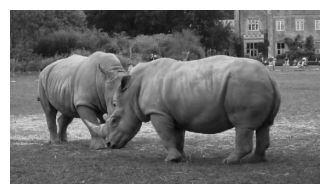

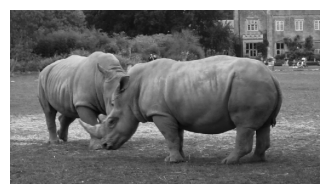

In [3]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter5/Input/")
inputImage1, width, height = imageReadL(pathToDir + image1Name)
inputImage2, _, _  = imageReadL(pathToDir + image2Name)

plotImageL(inputImage1, figureSize = 4) 
plotImageL(inputImage2, figureSize = 4)

### Reduce input image by sampling and by using a Gaussian filter

In [4]:
kernelSize = step * 4 
kernelCentre = int((kernelSize - 1) / 2)
gaussKernel = createGaussianKernel(kernelSize)

# Create images to store the smaller image
widthSmall = int(width / step)
heightSmall = int(height / step)
image1Small = createImageF(widthSmall, heightSmall)
image2Small = createImageF(widthSmall, heightSmall)

for x,y in itertools.product(range(0, widthSmall), range(0, heightSmall)):
    inputX = x * step
    inputY = y * step
    
    sumImage1 = 0.0
    sumImage2 = 0.0
    sumWeights = 0.0
    for wx,wy in itertools.product(range(0, kernelSize), range(0, kernelSize)):
        posY = inputY + wy - kernelCentre
        posX = inputX + wx - kernelCentre 
        
        if posY > -1 and posY <  height and  posX > -1 and posX <  width:
            sumImage1 += float(inputImage1[posY,posX]) * float(gaussKernel[wy, wx])
            sumImage2 += float(inputImage2[posY,posX]) * float(gaussKernel[wy, wx])
            sumWeights += float(gaussKernel[wy, wx])
    
    # If we have to normalize
    if sumWeights != 0.0:
        image1Small[y,x] = sumImage1 / sumWeights
        image2Small[y,x] = sumImage2 / sumWeights

### Compute motion in the reduced image

In [5]:
motion = createImageUV(widthSmall, heightSmall)
motionTemp = createImageUV(widthSmall, heightSmall)

for k in range(0,numIterations):
    for x,y in itertools.product(range(1, widthSmall-1), range(1, heightSmall-1)):
        
        # Derivatives
        gX = (float(image1Small[y,x+1]) - float(image1Small[y,x]) +            \
              float(image2Small[y,x+1]) - float(image2Small[y,x]) +            \
              float(image1Small[y+1,x+1]) - float(image1Small[y+1,x]) +        \
              float(image2Small[y+1,x+1]) - float(image2Small[y+1,x])) / 8.0
        
        gY = (float(image1Small[y+1,x]) - float(image1Small[y,x]) +            \
              float(image2Small[y+1,x]) - float(image2Small[y,x]) +            \
              float(image1Small[y+1,x+1]) - float(image1Small[y,x+1]) +        \
              float(image2Small[y+1,x+1]) - float(image2Small[y,x+1])) / 8.0
        
        gT = (float(image2Small[y,x]) - float(image1Small[y,x]) +              \
              float(image2Small[y+1,x]) - float(image1Small[y+1,x]) +          \
              float(image2Small[y,x+1]) - float(image1Small[y,x+1]) +          \
              float(image2Small[y+1,x+1]) - float(image1Small[y+1,x+1])) / 8.0
    
        # Average, but not use borders since the motion in borders is not defined
        average =[0.0, 0.0]
        n = 0.0
        for wx,wy in itertools.product(range(-1, 2), range(-1, 2)):
            posY, posX = y + wy, x + wx 
            if posY > 0 and posY <  heightSmall-1 and posX > 0 and             \
                                                    posX <  widthSmall-1:      
                average[0] += motion[posY,posX,0]
                average[1] += motion[posY,posX,1]
                n += 1.0
            
        if n != 0:
            average[0],  average[1] =  average[0]/ n, average[1] / n
        
        # Solve equation to update estimates
        A = float(gX * average[0] + gY * average[1] + gT)
        B = float(1.0 + smoothing * (gX*gX + gY*gY))
        motionTemp[y,x,0] = average[0] - (gX * smoothing * A / B)
        motionTemp[y,x,1] = average[1] - (gY * smoothing * A / B)
    
    # Update motion for next iteration
    for x,y in itertools.product(range(1, widthSmall-1), range(1, heightSmall-1)):
        motion[y,x,0] = motionTemp[y,x,0]
        motion[y,x,1] = motionTemp[y,x,1]

### Compute magnitude and angle

In [6]:
# Alternatively, this could be shown in low resolution
motionMagnitude = createImageF(width, height)
motionDirection = createImageF(width, height)
for x,y in itertools.product(range(1, widthSmall-1), range(1, heightSmall-1)):
    inputX = x * step
    inputY = y * step
    # The size is multiplied by sampling to define motion in high resolution
    motionMagnitude[inputY,inputX] = sqrt(motion[y,x,0] * motion[y,x,0] +         \
                                     motion[y,x,1] * motion[y,x,1]) * step
    motionDirection[inputY,inputX] = atan2( motion[y,x,1],  -motion[y,x,0])
        

# Plot vectors

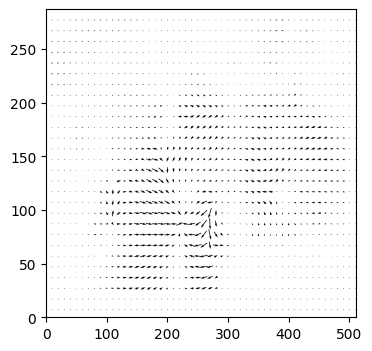

In [7]:
plotQuiver(motionMagnitude, motionDirection, .5, step)